In [4]:
import pandas as pd
from konlpy.tag import Okt

okt = Okt()

word_dictionary = pd.read_csv("../data/processed/word_dictionary.csv", sep=',')
news1 = pd.read_csv("../data/processed/news/detail/news_donga_preprocessed.csv", sep=',', encoding='cp949')
news2 = pd.read_csv("../data/processed/news/detail/news_chosun_preprocessed.csv", sep=',', encoding='cp949')
news3 = pd.read_csv("../data/processed/news/detail/nie_chosun_preprocessed.csv", sep=',', encoding='cp949')


word_level_dict = word_dictionary.set_index('Word')['Level'].to_dict()

def calculate_word_metrics(content, word_level_dict):
    if not isinstance(content, str):
        content = ""
        
    tokens = okt.morphs(content)
    word_count = len(tokens)
    length = len(content)
    
    levels = [word_level_dict[token] for token in tokens if token in word_level_dict]
    
    if levels:
        word_avg = sum(levels) / len(levels)
        word_high = max(levels)
    else:
        word_avg = 0
        word_high = 0
    
    return word_count, word_avg, word_high, length

news1[['word_count', 'word_avg', 'word_hard', 'length']] = news1['preprocessed_content'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)
news2[['word_count', 'word_avg', 'word_hard', 'length']] = news2['preprocessed_content'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)
news3[['word_count', 'word_avg', 'word_hard', 'length']] = news3['preprocessed_content'].apply(
    lambda content: pd.Series(calculate_word_metrics(content, word_level_dict))
)

In [5]:
news1 = news1[news1['word_count'] >= 70].reset_index(drop=True)
news2 = news2[news2['word_count'] >= 70].reset_index(drop=True)
news3 = news3[news3['word_count'] >= 70].reset_index(drop=True)

In [6]:
news1.to_csv("../data/processed/news/detail/news_donga_with_metrics.csv", sep=',', encoding='utf-8-sig', index=False)
news2.to_csv("../data/processed/news/detail/news_chosun_with_metrics.csv", sep=',', encoding='utf-8-sig', index=False)
news3.to_csv("../data/processed/news/detail/nie_chosun_with_metrics.csv", sep=',', encoding='utf-8-sig', index=False)

In [7]:
# news3.drop(['question'], axis=1, inplace=True)
news = pd.concat([news1, news2, news3], ignore_index=True)
print(news)
news.to_csv("../data/processed/news/detail/news_all.csv", sep=',', encoding='utf-8-sig', index=False)

                                                   URL  \
0    https://kids.donga.com/?ptype=article&no=20240...   
1    https://kids.donga.com/?ptype=article&no=20240...   
2    https://kids.donga.com/?ptype=article&no=20240...   
3    https://kids.donga.com/?ptype=article&no=20240...   
4    https://kids.donga.com/?ptype=article&no=20240...   
..                                                 ...   
874  https://bbs.chosun.com/messageview/view.bbs?bb...   
875  https://bbs.chosun.com/messageview/view.bbs?bb...   
876  https://bbs.chosun.com/messageview/view.bbs?bb...   
877  https://bbs.chosun.com/messageview/view.bbs?bb...   
878  https://bbs.chosun.com/messageview/view.bbs?bb...   

                                                 title  \
0           [뉴스 브리핑]?도심 속 호수에 떠오른 16m 높이 대형 ‘랍스터’ 정체는?   
1    [뉴스 브리핑]?소방청, 추석 음식 만들 때 화재 주의… “불나면 젖은 수건 덮으세요!”   
2       생활 속으로 들어온 ‘작은 태양 전지’… 모자로 쓰고, 휴대폰에 붙여서 에너지 쏙!   
3                        [월드 뉴스]?화려하게 폐막한 2024 파리 패럴림픽   
4            

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


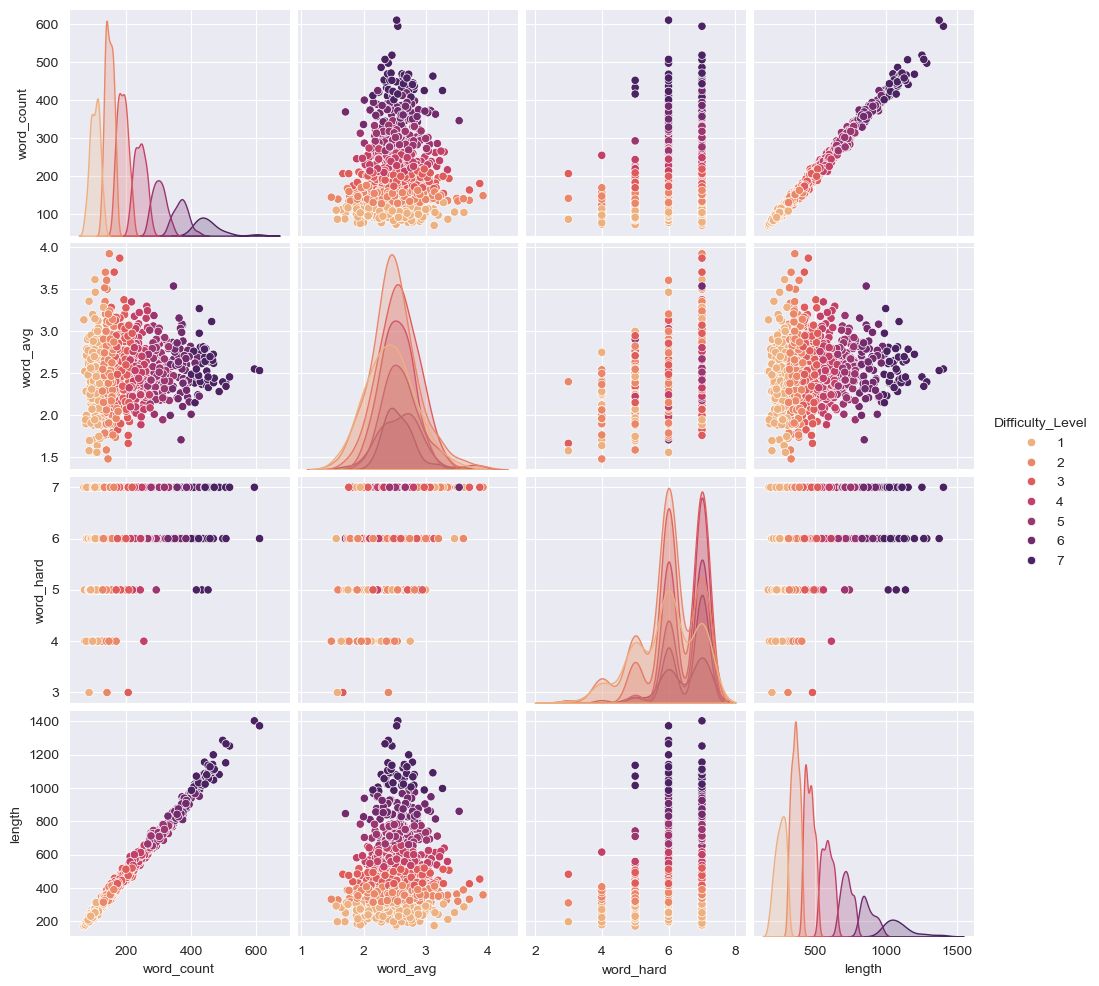

Saved difficulty levels to ../data/processed/news/result/news_level.csv


In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# K-means 적용
n_clusters = 7 
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
news['Cluster'] = kmeans.fit_predict(news[['word_count', 'word_avg', 'word_hard', 'length']])

# word_high 평균값이 높은 클러스터부터 높은 난이도로 분류
cluster_avg = news.groupby('Cluster')['length'].mean().sort_values()
cluster_avg_rank = cluster_avg.rank().astype(int)
difficulty_mapping = {cluster: rank for cluster, rank in zip(cluster_avg.index, cluster_avg_rank)}
news['Difficulty_Level'] = news['Cluster'].map(difficulty_mapping)

# 시각화
features = ['word_count', 'word_avg', 'word_hard', 'length', 'Difficulty_Level']
sns_plot = sns.pairplot(news[features], hue='Difficulty_Level', palette='flare')
image_path = "../data/processed/news/detail/news_level_pairplot.png"
sns_plot.savefig(image_path)
plt.show()


file_path = "../data/processed/news/result/news_level.csv"
news.to_csv(file_path, index=False, sep=',', encoding='utf-8-sig')
print(f"Saved difficulty levels to {file_path}")
